In [1]:

'''#### EXERCÍCIO 3 #### '''

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import CubicSpline
from scipy.misc import derivative

In [2]:

#----> PONTOS DA CURVA <----#

#Pontos obtidos no geogebra
HB  = [(-50.475, 0),(-50.2673998412629, 0.0796361053289),(-48.9626776867512, 0.3668760480514),(-47.6963297132546, 0.6124006463951),(-46.9149619282718, 0.7345571237282),(-45.1594078398158, 0.8312166828278),(-42.2866829677967, 0.9278762419274),(-39.9725434875592, 0.9675314456605),(-36.2220415713121, 1.0270142512603),(-31.1947730452789, 1.0741048056934),(-28.0028565208133, 1.0988893080266),(-24.2523546045662, 1.1261522605932),(-21.2998318194356, 1.1385445117598),(-17.5493299031885, 1.1484583126931),(-14.1978175524997, 1.163329014093),(-9.9685281575828, 1.170764364793),(-5.8988345888892, 1.1856350661929),(-1.3503535415257, 1.1930704168929),(0, 1.20)]

#H = [-50267.4, -48962.7, -47696.3, -46915.0, -45159.4, -42286.7, -39972.5, -36222.0, -31194.8, -28002.9, -24252.4, -21299.8, -17549.3, -14197.8, -9968.5, -5898.8, -1350.4]
#B = [0.08, 0.367, 0.612, 0.735, 0.831, 0.928, 0.968, 1.027, 1.074, 1.099, 1.126, 1.139, 1.148, 1.163, 1.171, 1.186, 1.193]

Hm = []
Bm = []

for hb in HB:
  Hm.append(hb[0]*1e3)
  Bm.append(hb[1])

Hm = np.array(Hm)
Bm = np.array(Bm)

#Ponto de operação normal
Hm_op = -31.0876288659794*1e3
Bm_op = 1.0712299465241

#Valores de Br e Hc
Hc = Hm[0]
Br = Bm[-1]


In [3]:

#----> CONSTANTES <----#
numPontos = 100

Wm = 2e-2         #Largura do ímã
Wg = 2.5e-2       #Largura do entreferro
D = 3e-2          #Espessura do núcleo
d = 1e-2          #comprimento do ímã
g = 0.2e-2        #comprimento do entreferro
u0 = 4*np.pi*1e-7 #Permeabilidade do ar


<ipython-input-4-ebe21aed0862>:90: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  F_real = derivative(curvaWcxX_real, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)
<ipython-input-4-ebe21aed0862>:91: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  F_linear = derivative(curvaWcxX_linear, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)


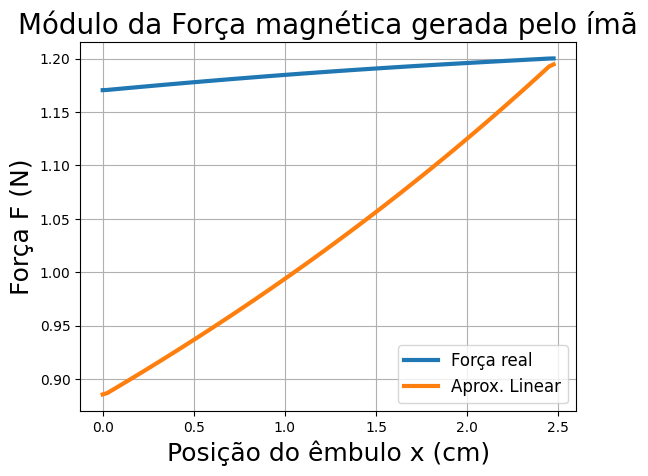

In [4]:

'''
#---------------------------#
#--------> PARTE 1 <--------#
#-> Deteriminando a força <-#
#---------------------------#
'''

#Corrente na bobina
Ibob = 0

#Determinando as curvas
curvaHxB_real = CubicSpline(Bm, Hm, bc_type='natural')
curvaHxB_linear = CubicSpline((0, Br), (Hc, 0), bc_type='natural')


#Define um intervalo de variação para Bm
BmInt = np.linspace(0, np.max(Bm), numPontos)


#Gera um vetor de Hm real e linear em função de Bm
Hm_real = curvaHxB_real(BmInt)
Hm_linear = curvaHxB_linear(BmInt)


#N° de espiras do método da bobina fictícea
Nf = 1000


#Determina um intervalo de variação de lambda em função de Bm
Am = Wm*D #Área do ímã
lambdaInt = Nf*Am*BmInt


#Determina um intervalo de variação de x
xInt = np.linspace(0, Wg, numPontos+1)[:-1] #Exlcui o último elemento


#Cria os vetores da coenergia
wc_real = []
wc_linear = []


#Avalia o sistema para cada x
for x in xInt:

  Ag = D*(Wg-x) #Área do entreferro

  #Determinando as correntes fictíceas
  If_real = (Hm_real*d + 2*g*(BmInt*Am)/(u0*Ag))/Nf
  If_linear = (Hm_linear*d + 2*g*(BmInt*Am)/(u0*Ag))/Nf


  #Determinando as curvas fluxo concatenado por corrente
  curvaLambdaCxI_real = CubicSpline(If_real, lambdaInt, bc_type='natural')
  curvaLambdaCxI_linear = CubicSpline(If_linear, lambdaInt, bc_type='natural')


  #Determinando a corrente que zera o fluxo
  curvaIxLambdaC_real = CubicSpline(lambdaInt, If_real, bc_type='natural')
  curvaIxLambdaC_linear = CubicSpline(lambdaInt, If_linear, bc_type='natural')

  I0_real = curvaIxLambdaC_real(0)
  I0_linear = curvaIxLambdaC_linear(0)


  #Determina o intervalo de variação da corrente fictícea [de I0 até Ibob = 0]
  IfInt_real = np.linspace(I0_real, Ibob, numPontos)
  IfInt_linear = np.linspace(I0_linear, Ibob, numPontos)


  #Determina o fluxo para a região de corrente desejada
  lambdaC_real = curvaLambdaCxI_real(IfInt_real)
  lambdaC_linear = curvaLambdaCxI_linear(IfInt_linear)


  #Adiciona ao vetor de coenergia o valor da coenergia para o x da vez
  wc_real.append(sp.integrate.trapezoid(lambdaC_real, IfInt_real))
  wc_linear.append(sp.integrate.trapezoid(lambdaC_linear, IfInt_linear))


wc_real = np.array(wc_real)
wc_linear = np.array(wc_linear)

#Curvas da coernegia pela variação de x
curvaWcxX_real = CubicSpline(xInt, wc_real, bc_type='natural')
curvaWcxX_linear = CubicSpline(xInt, wc_linear, bc_type='natural')


#Determinando a força derivando wc em relação a x
F_real = derivative(curvaWcxX_real, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)
F_linear = derivative(curvaWcxX_linear, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)


#Plotando o gráfico

plt.figure(1)

plt.plot(xInt*100, np.abs(F_real), label='Força real', linewidth = 3)
plt.plot(xInt*100, np.abs(F_linear), label='Aprox. Linear', linewidth = 3)
plt.title('Módulo da Força magnética gerada pelo ímã',fontsize=20)
plt.xlabel('Posição do êmbulo x (cm)', fontsize=18)
plt.ylabel('Força F (N)', fontsize=18)
plt.legend(fontsize=12)
plt.grid()


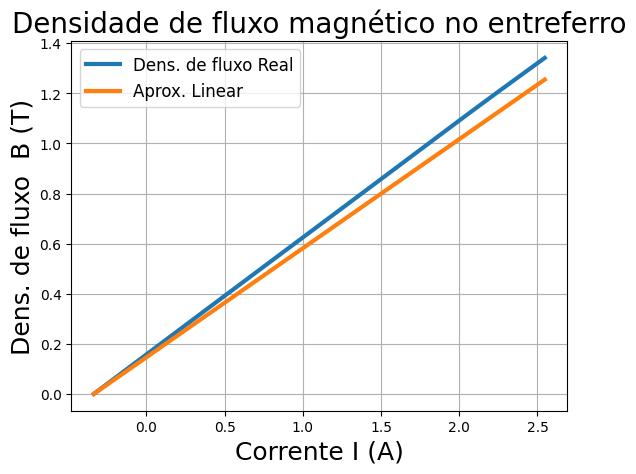

In [5]:

'''
#---------------------------------------#
#--------------> PARTE 2 <--------------#
#-> Densiadade de fluxo no entreferro <-#
#---------------------------------------#
'''

#N° de espiras
N = 1500


#Determinando as curvas
curvaHxB_real = CubicSpline(Bm, Hm, bc_type='natural')
curvaHxB_linear = CubicSpline((0, Br), (Hc, 0), bc_type='natural')

#Intervalo de variação de Bm
BmInt = np.linspace(0, np.max(Bm), numPontos)


#Determinando os Hm
Hm_real = curvaHxB_real(BmInt)
Hm_linear = curvaHxB_linear(BmInt)


#Posição utilizada
x = Wg/2

#Áreas
Am = Wm*D       #Ímã
Ag = (Wg-x)*D   #Entreferro


#Densidade de fluxo magnético no enteferro
Bg = BmInt*Am/Ag


#Determinando a corrente pela lei de Àmpere
I_real = (Hm_real*d + 2*g*Bg/u0)/N
I_linear = (Hm_linear*d + 2*g*Bg/u0)/N


#Determinando a curva Bg x I
curvaBgXI_real = CubicSpline(I_real, Bg, bc_type='natural')
curvaBgXI_linear = CubicSpline(I_linear, Bg, bc_type='natural')


#Determinando a corrente que anula o fluxo
curvaIxBg = CubicSpline(Bg, I_real, bc_type='natural')
I0 = curvaIxBg(0)


#Calcula a corrente maxima para ter precisão na interpolação
IbobMax = (np.max(Hm_real)*d + 2*g*np.max(Bm)/u0)/N #Para x = 0 -> Ag = Am


#Intervalo de corrente na bobina
Iint = np.linspace(I0, IbobMax, numPontos)

#Determina a densidade de fluxo no entreferro em função de Iint
Bg_real = curvaBgXI_real(Iint)
Bg_linear = curvaBgXI_linear(Iint)

#Plota os gráficos

plt.figure(2)

plt.plot(Iint, Bg_real, label='Dens. de fluxo Real', linewidth = 3)
plt.plot(Iint, Bg_linear, label='Aprox. Linear', linewidth = 3)
plt.title('Densidade de fluxo magnético no entreferro',fontsize=20)
plt.xlabel('Corrente I (A)', fontsize=18)
plt.ylabel('Dens. de fluxo  B (T)', fontsize=18)
plt.legend(fontsize=12)
plt.grid()


<ipython-input-6-5aba1ec04781>:115: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  F_real = derivative(curvaWcxX_real, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)
<ipython-input-6-5aba1ec04781>:116: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  F_linear = derivative(curvaWcxX_linear, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)


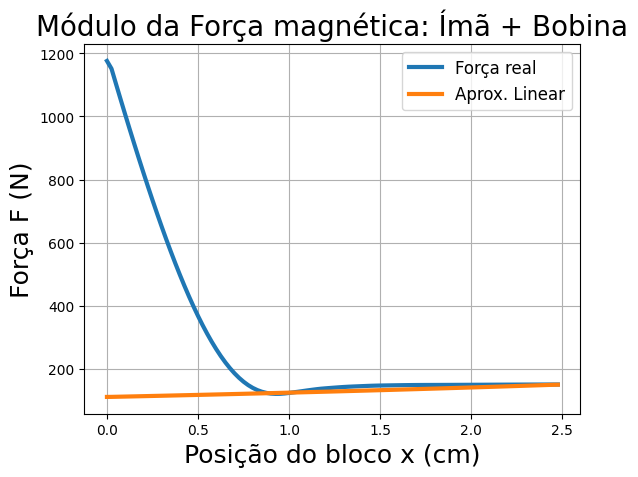

In [6]:

'''
#---------------------------------------#
#--------------> PARTE 3 <--------------#
#----> Força magnética (Ibob > 0) <-----#
#---------------------------------------#
'''

#-----> Determinando a corrente de Operação para x = Wg/2 <-----#

#N° de espiras
N = 1500

#posição e Áreas
x = Wg/2
Ag = D*(Wg-x)
Am = D*Wm

#Campo no entreferro quando o ímã está no ponto de operação
Bg_op = Bm_op*Am/Ag

#Corrente de operação pela lei de Ampere
I_op = (Hm_op*d + 2*g*Bg_op/u0)/N


#--------------------------------------------------------------------

#----> Repetindo a Parte 1 para quando Ibob = I_op <----#

#Corrente na bobina
Ibob = I_op

#Determinando as curvas
curvaHxB_real = CubicSpline(Bm, Hm, bc_type='natural')
curvaHxB_linear = CubicSpline((0, Br), (Hc, 0), bc_type='natural')


#Define um intervalo de variação para Bm
BmInt = np.linspace(0, np.max(Bm), numPontos)


#Gera um vetor de Hm real e linear em função de Bm
Hm_real = curvaHxB_real(BmInt)
Hm_linear = curvaHxB_linear(BmInt)


#N° de espiras da bobina
N = 1500

#Área do ímã
Am = Wm*D

#Determina um intervalo de variação de lambda em função de Bm
lambdaInt = N*Am*BmInt


#Determina um intervalo de variação de x
xInt = np.linspace(0, Wg, numPontos+1)[:-1] #Remove o último elemento


#Cria os vetores da coenergia
wc_real = []
wc_linear = []


#Avalia o sistema para cada x
for x in xInt:

  Ag = D*(Wg-x) #Área do entreferro

  #Densidade de fluxo no enteferro
  Bg = BmInt*Am/Ag

  #Determinando as correntes pela lei de Ampere
  I_real = (Hm_real*d + 2*g*Bg/u0)/N
  I_linear = (Hm_linear*d + 2*g*Bg/u0)/N


  #Determinando as curvas fluxo concatenado por corrente
  curvaLambdaCxI_real = CubicSpline(I_real, lambdaInt, bc_type='natural')
  curvaLambdaCxI_linear = CubicSpline(I_linear, lambdaInt, bc_type='natural')


  #Determinando a corrente que zera o fluxo
  curvaIxLambdaC_real = CubicSpline(lambdaInt, I_real, bc_type='natural')
  curvaIxLambdaC_linear = CubicSpline(lambdaInt, I_linear, bc_type='natural')

  I0_real = curvaIxLambdaC_real(0)
  I0_linear = curvaIxLambdaC_linear(0)


  #Determina o intervalo de variação da corrente
  Iint_real = np.linspace(I0_real, Ibob, numPontos)
  Iint_linear = np.linspace(I0_linear,Ibob, numPontos)


  #Determina o fluxo na região de corrente desejada
  lambdaC_real = curvaLambdaCxI_real(Iint_real)
  lambdaC_linear = curvaLambdaCxI_linear(Iint_linear)


  #Adiciona ao vetor de coenergia o valor da coenergia para o x da vez
  wc_real.append(sp.integrate.trapezoid(lambdaC_real, Iint_real))
  wc_linear.append(sp.integrate.trapezoid(lambdaC_linear, Iint_linear))


wc_real = np.array(wc_real)
wc_linear = np.array(wc_linear)


#Curvas da coenergia pela variação de x
curvaWcxX_real = CubicSpline(xInt, wc_real, bc_type='natural')
curvaWcxX_linear = CubicSpline(xInt, wc_linear, bc_type='natural')

#Determinando a força derivando wc em relação a x
F_real = derivative(curvaWcxX_real, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)
F_linear = derivative(curvaWcxX_linear, xInt, dx=(np.max(xInt)-np.min(xInt))/numPontos)


#Plotando o gráfico
plt.figure(3)
plt.plot(xInt*100, np.abs(F_real), label='Força real', linewidth = 3)
plt.plot(xInt*100, np.abs(F_linear), label='Aprox. Linear', linewidth = 3)
plt.title('Módulo da Força magnética: Ímã + Bobina', fontsize = 20)
plt.xlabel('Posição do bloco x (cm)', fontsize = 18)
plt.ylabel('Força F (N)', fontsize = 18)
plt.legend(fontsize = 12)
plt.grid()
